# Yolo Usage Image Processing Sample... 


### YOLO USAGE SAMPLE CODE, From Single Image or Multiple Images or Video File or WebCam
### This is just a sample code. We prefer not to use jupyter notebooks when we are dealing with image/video previews.
### if processing VIDEO FILE is taking too much time disable it ( disabled by default)
### output folder will record ALL RESULTS !!! (as video or image)
# Have Fun  :) !!




### any questions about this should be directed to hasan@clarusway.com or via SLACK -> EN Section


In [1]:
import numpy as np
import argparse
import cv2
import os
import time
import matplotlib.pyplot as plt
from datetime import datetime
from os import listdir
from os.path import isfile, join
from io import StringIO 
from io import BytesIO
import signal
import sys
plt.rcParams["figure.figsize"] = (200,24)


from PIL import Image
import PIL.Image
import wget

### pip3 install Pillow
or
### conda install Pillow


### pip3 install wget
or
### conda install -c conda-forge wget


### pip3 install opencv-python
or
###  conda install -c conda-forge opencv 



### Variables

In [2]:
WEIGHTS_FILE = "model/yolov3.weights"
CONFIG_FILE = "model/yolov3.cfg"
LABELS_FILE = "model/coco.names"
CONFIDENCE = 0.5 #minimum confidence for a box to be detected
THRESHOLD = 0.3 # threshold for NON-MAX Supression
USE_GPU = False # if you have cuda enabled use True, dont forget you have to compile opencv dnn module with cuda support
SAVE_OUTPUT = True
SINGLE_IMAGE_PATH = 'images/dog.jpg' # pass path of the image to be processes.. 
MULIPLE_IMAGE_PATH= 'images_multiple'
VIDEO_PATH = ''#'funny_cat_dog.mp4' # it is taking time..if you wish to process a video file , give it the path
WEBCAM = '0' # if you wish to open webcam change it to 0 for default webcam or 1 2 3 according to number of webcams you have
is_interrupted = False # capture interruption on webcam or file

### Lets first check if you have READY to USE MODEL!!

In [3]:
import wget
 
url_weights = "https://pjreddie.com/media/files/yolov3.weights"

if  os.path.exists(WEIGHTS_FILE) == False :
    wget.download(url_weights, WEIGHTS_FILE)
    


100% [......................................................................] 248007048 / 248007048

### HElper Functions

In [4]:
def extract_boxes_confidences_classids(outputs, confidence, width, height):
    boxes = []
    confidences = []
    classIDs = []

    for output in outputs:
        for detection in output:            
            # Extract the scores, classid, and the confidence of the prediction
            scores = detection[5:]
            classID = np.argmax(scores)
            conf = scores[classID]
            
            # Consider only the predictions that are above the confidence threshold
            if conf > confidence:
                # Scale the bounding box back to the size of the image
                box = detection[0:4] * np.array([width, height, width, height])
                centerX, centerY, w, h = box.astype('int')

                # Use the center coordinates, width and height to get the coordinates of the top left corner
                x = int(centerX - (w / 2))
                y = int(centerY - (h / 2))

                boxes.append([x, y, int(w), int(h)])
                confidences.append(float(conf))
                classIDs.append(classID)

    return boxes, confidences, classIDs


def draw_bounding_boxes(image, boxes, confidences, classIDs, idxs, colors):
    if len(idxs) > 0:
        for i in idxs.flatten():
            # extract bounding box coordinates
            x, y = boxes[i][0], boxes[i][1]
            w, h = boxes[i][2], boxes[i][3]

            # draw the bounding box and label on the image
            color = [int(c) for c in colors[classIDs[i]]]
            cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
            text = "{}: {:.4f}".format(labels[classIDs[i]], confidences[i])
            cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    return image


def make_prediction(net, layer_names, labels, image, confidence, threshold):
    height, width = image.shape[:2]
    
    # Create a blob and pass it through the model
    blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    outputs = net.forward(layer_names)

    # Extract bounding boxes, confidences and classIDs
    boxes, confidences, classIDs = extract_boxes_confidences_classids(outputs, confidence, width, height)

    # Apply Non-Max Suppression
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, confidence, threshold)

    return boxes, confidences, classIDs, idxs



def signal_handler(signal, frame):
    # KeyboardInterrupt detected, exiting
    
    is_interrupted = True
    
 
#Convert image to jpeg binary and display with Ipython
def show(a, fmt='jpeg'):
    f = BytesIO()
    Image.fromarray(a).save(f, fmt) # (3)
    IPython.display.display(IPython.display.Image(data=f.getvalue())) # (4)    

In [5]:

# Get the labels
labels = open(LABELS_FILE).read().strip().split('\n')
labels

['person',
 'bicycle',
 'car',
 'motorbike',
 'aeroplane',
 'bus',
 'train',
 'truck',
 'boat',
 'traffic light',
 'fire hydrant',
 'stop sign',
 'parking meter',
 'bench',
 'bird',
 'cat',
 'dog',
 'horse',
 'sheep',
 'cow',
 'elephant',
 'bear',
 'zebra',
 'giraffe',
 'backpack',
 'umbrella',
 'handbag',
 'tie',
 'suitcase',
 'frisbee',
 'skis',
 'snowboard',
 'sports ball',
 'kite',
 'baseball bat',
 'baseball glove',
 'skateboard',
 'surfboard',
 'tennis racket',
 'bottle',
 'wine glass',
 'cup',
 'fork',
 'knife',
 'spoon',
 'bowl',
 'banana',
 'apple',
 'sandwich',
 'orange',
 'broccoli',
 'carrot',
 'hot dog',
 'pizza',
 'donut',
 'cake',
 'chair',
 'sofa',
 'pottedplant',
 'bed',
 'diningtable',
 'toilet',
 'tvmonitor',
 'laptop',
 'mouse',
 'remote',
 'keyboard',
 'cell phone',
 'microwave',
 'oven',
 'toaster',
 'sink',
 'refrigerator',
 'book',
 'clock',
 'vase',
 'scissors',
 'teddy bear',
 'hair drier',
 'toothbrush']

In [6]:
# Create a list of colors for the labels
colors = np.random.randint(0, 255, size=(len(labels), 3), dtype='uint8')

In [7]:
# Load weights using OpenCV
net = cv2.dnn.readNetFromDarknet(CONFIG_FILE, WEIGHTS_FILE)

In [8]:
if USE_GPU :
    print("USING GPU !!")
    net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
    net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

In [9]:
if SAVE_OUTPUT :
    os.makedirs('output', exist_ok=True)

In [10]:
# Get the ouput layer names
layer_names = net.getLayerNames()

layer_names = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]
# if you are using a old version of opencv use the line below
#layer_names = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

layer_names
   

['yolo_82', 'yolo_94', 'yolo_106']

In [11]:
## check image path
if SINGLE_IMAGE_PATH != '':
    image = cv2.imread(SINGLE_IMAGE_PATH)
    boxes, confidences, classIDs, idxs = make_prediction(net, layer_names, labels, image, CONFIDENCE,THRESHOLD)
    image = draw_bounding_boxes(image, boxes, confidences, classIDs, idxs, colors)
  
    

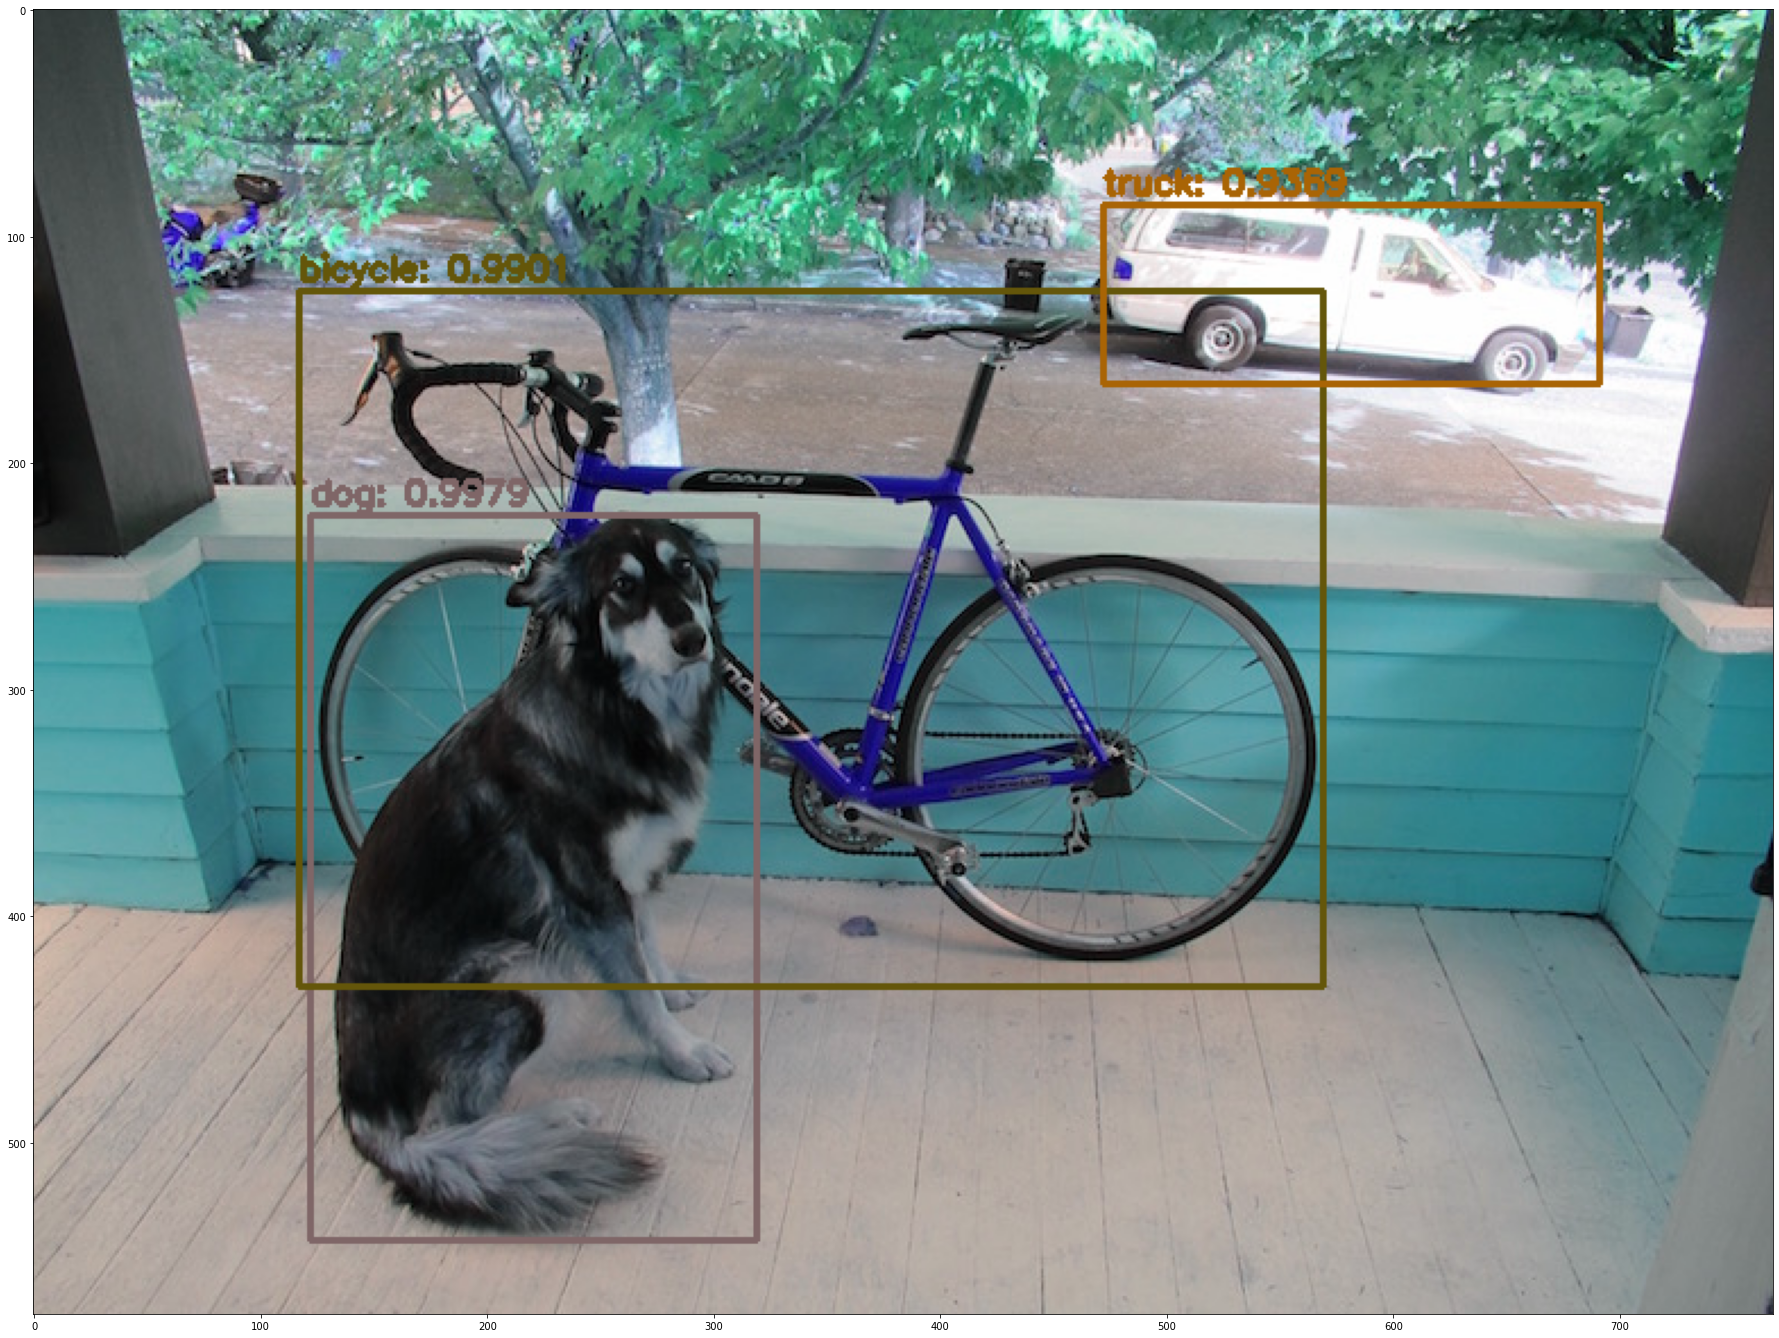

In [12]:
from matplotlib import pyplot as plt
img2 = image[:,:,::-1]
plt.imshow(image)

In [13]:
## check image path
if SINGLE_IMAGE_PATH != '':
    image = cv2.imread(SINGLE_IMAGE_PATH)
    boxes, confidences, classIDs, idxs = make_prediction(net, layer_names, labels, image, CONFIDENCE,THRESHOLD)
    image = draw_bounding_boxes(image, boxes, confidences, classIDs, idxs, colors)
    
    
    if SAVE_OUTPUT :
        now = datetime.now()
        dt_string = now.strftime("%d_%m_%Y__%H_%M_%S")
        cv2.imwrite(f'output/{"SINGLE_IMAGE_" +dt_string+ SINGLE_IMAGE_PATH.split("/")[-1]}', image)

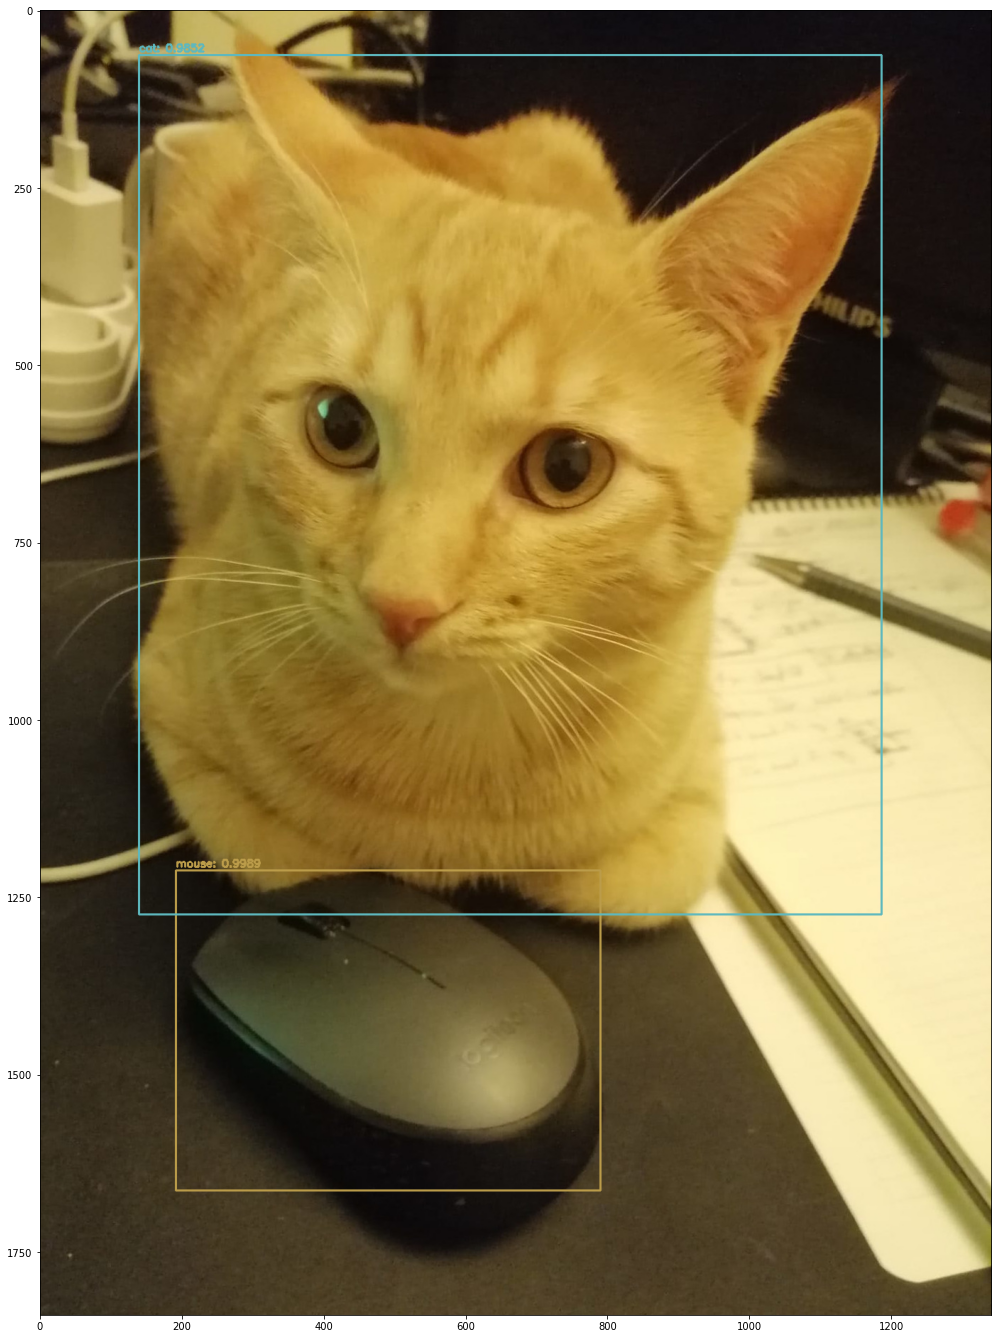

In [14]:
## check image path
if MULIPLE_IMAGE_PATH != '':
    onlyfiles = [f for f in listdir(MULIPLE_IMAGE_PATH) if isfile(join(MULIPLE_IMAGE_PATH, f))]
    onlyfiles
    for f in onlyfiles :
        myfile= os.path.join(MULIPLE_IMAGE_PATH, f)
        image = cv2.imread(myfile)
        boxes, confidences, classIDs, idxs = make_prediction(net, layer_names, labels, image, CONFIDENCE,THRESHOLD)
        image = draw_bounding_boxes(image, boxes, confidences, classIDs, idxs, colors)
        # IF It is  My sons cat MINNOS :P
        if f == "minno.jpeg":
            img2 = image[:,:,::-1]
            plt.imshow(img2)
        if SAVE_OUTPUT :
            now = datetime.now()
            dt_string = now.strftime("%d_%m_%Y__%H_%M_%S")
            cv2.imwrite(f'output/{"MULTIPLE_IMAGE_PATH_" +dt_string+ "_"+f.split("/")[-1]}', image)

### Now the tricky part video file or Webcam

In [15]:
if VIDEO_PATH != '':
    cap = cv2.VideoCapture(VIDEO_PATH)
    width = int(cap.get(3))
    height =int(cap.get(4))
    fps =cap.get(cv2.CAP_PROP_FPS)
    name =VIDEO_PATH.split("/")[-1] if VIDEO_PATH else 'camera.avi'
    now = datetime.now()
    dt_string = now.strftime("%d_%m_%Y__%H_%M_%S")
    out=cv2.VideoWriter(f'output/{"VIDEO_FILE_"+dt_string+"_output.avi"}', cv2.VideoWriter_fourcc('M','J','P','G'), fps, (width, height))
    
    
    plt.ion()
    if cap.isOpened(): # try to get the first frame
        is_capturing, frame = cap.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)    # makes the blues image look real colored
        video_preview = plt.imshow(frame,interpolation='None', animated=True)    
    else:
        is_capturing = False
    try:    
        while is_capturing:
            is_capturing,image = cap.read()
            boxes, confidences, classIDs, idxs = make_prediction(net, layer_names, labels, image, CONFIDENCE, THRESHOLD)
            image = draw_bounding_boxes(image, boxes, confidences, classIDs, idxs, colors)
            frame = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            #im_pil = Image.fromarray(frame)
            show(frame) # (3-4)
            IPython.display.clear_output(wait=True)

            if is_capturing == False :
                cap.release();
                break

            if SAVE_OUTPUT :
                out.write(image)
        cap.release()
        out.release()
    except KeyboardInterrupt:
        cap.release()
        out.release()
     
        

### webcam


In [16]:
import pandas as pd
if WEBCAM != '':
    url = "https://en.wikipedia.org/wiki/List_of_common_resolutions"
    table = pd.read_html(url)[0]
    table.columns = table.columns.droplevel()
    cap = cv2.VideoCapture(int(WEBCAM))
    resolutions = {}

    for index, row in table[["W", "H"]].iterrows():
        cap.set(cv2.CAP_PROP_FRAME_WIDTH, row["W"])
        cap.set(cv2.CAP_PROP_FRAME_HEIGHT, row["H"])
        width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
        height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
        resolutions[str(width)+"x"+str(height)] = "OK"

    print(resolutions)

{'320.0x240.0': 'OK', '640.0x480.0': 'OK'}


In [17]:
if WEBCAM != '':
    cap = cv2.VideoCapture(int(WEBCAM))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height =int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps =10.0
    name ='webcam.avi'
    now = datetime.now()
    dt_string = now.strftime("%d_%m_%Y__%H_%M_%S")
    out=cv2.VideoWriter(f'output/{"WEBCAM_FILE_"+dt_string+"_output.avi"}', cv2.VideoWriter_fourcc('X','V','I','D'), fps, (width, height))
    
    
    plt.ion()
    if cap.isOpened(): # try to get the first frame
        is_capturing, frame = cap.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)    # makes the blues image look real colored
        video_preview = plt.imshow(frame,interpolation='None', animated=True)    
    else:
        is_capturing = False
    try:    
        while is_capturing:
            is_capturing,image = cap.read()
            boxes, confidences, classIDs, idxs = make_prediction(net, layer_names, labels, image, CONFIDENCE, THRESHOLD)
            image = draw_bounding_boxes(image, boxes, confidences, classIDs, idxs, colors)
            frame = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            #im_pil = Image.fromarray(frame)
            show(frame) # (3-4)
            IPython.display.clear_output(wait=True)

            if is_capturing == False :
                cap.release();
                break

            if SAVE_OUTPUT :
                out.write(image)
        cap.release()
        out.release()
    except KeyboardInterrupt:
        cap.release()
        out.release()
     


[ WARN:0@114.736] global /io/opencv/modules/videoio/src/cap_v4l.cpp (889) open VIDEOIO(V4L2:/dev/video0): can't open camera by index
